# 1 - Perkenalan

Name : Prajna


Batch : 015


Dataset : Malaria parasite in blood smears


Objectives : Detect malaria in blood smears


# 2 - Import Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Dense, Dropout, Flatten

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
from PIL import Image
import joblib
import json
import numpy as np
from google.colab import files
from keras import utils
from keras.utils import load_img
from keras.preprocessing import image

# 3 - Data Loading

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 2.9 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73051 sha256=95b4c17c9944ff3fa7c6270cb32e9d913c31dd21ebfe11f3ffb4fcfd53a66882
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [ ]:
!mkdir -p ~/.kaggle #bikin folder di kaggle root
!cp kaggle.json ~/.kaggle # copy paster kaggle.json ke folder kaggle 

!mkdir ./kaggle #bikin folder kaggle di lokasi sama (bukan di root)
!mv ./kaggle.json ./kaggle #move atau pindahi file kaggle.json ke folder kaggle

mkdir: cannot create directory ‘./kaggle’: File exists


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json #perizinan akses, hanya pemilik file yang memiliki akses baca dan tulis ke file
!ls ~/.kaggle #cek list data yang ada di folder kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d miracle9to9/files1 --force

 97% 510M/525M [00:03<00:00, 182MB/s]
100% 525M/525M [00:03<00:00, 144MB/s]


In [ ]:
# !unzip -q /content/labeled-chest-xray-images.zip -d dataset
!unzip -q //content/files1.zip -d images

replace images/Malaria Cells/single_prediction/Parasitised.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace images/Malaria Cells/single_prediction/Parasitised.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: a
error:  invalid response [a]
replace images/Malaria Cells/single_prediction/Parasitised.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
a


In [ ]:
os.listdir('/content/images/Malaria Cells')

['single_prediction', 'training_set', 'testing_set']

In [ ]:
main_path = '/content/images/Malaria Cells'

In [ ]:
train_dir = os.path.join(main_path, 'training_set')
test_dir = os.path.join(main_path, 'testing_set')
inf = os.path.join(main_path, 'single_prediction')

In [ ]:
print('Train set: \n' + '='*50)
num_malaria= len(os.listdir(os.path.join(train_dir, 'Parasitized')))
num_normal= len(os.listdir(os.path.join(train_dir, 'Uninfected')))
print(f'Jumlah malaria = {num_malaria}')
print(f'Jumlah normal = {num_normal}')

Train set: 
Jumlah malaria = 13780
Jumlah normal = 13780


terdapat 13780 data image malaria dan 13780 data image normal pada train set, data seimbang

In [ ]:
  print('Test set: \n' + '='*50)
  num_malaria= len(os.listdir(os.path.join(test_dir, 'Parasitized')))
  num_normal= len(os.listdir(os.path.join(test_dir, 'Uninfected')))
  print(f'Jumlah malaria = {num_malaria}')
  print(f'Jumlah normal = {num_normal}')

Test set: 
Jumlah malaria = 7952
Jumlah normal = 7880


terdapat 7952 data image malaria dan 7880 data image normal pada test set

In [ ]:
train_normal = glob.glob(train_dir+"/Uninfected/*.png")
train_malaria = glob.glob(train_dir+"/Parasitized/*.png")

test_normal = glob.glob(test_dir+"/Uninfected/*.png")
test_malaria = glob.glob(test_dir+"/Parasitized/*.png")

# 4 - Exploratory Data Analysis

In [ ]:
def create_dataframe(list_of_images):
    data = []
    for image in list_of_images:
        ##ambil nama dari file \ ke -1
        #images.append(image.split(main_path)[-1]) 
        #label.append(image.split(main_path)[-2])
        data.append((image, image.split('/')[-2]))
    return pd.DataFrame(data, columns=['images', 'label'])

train_data = create_dataframe(train_normal + train_malaria)
train_data = train_data.sample(frac=1, random_state=0).reset_index(drop=True)

test_data = create_dataframe(test_normal + test_malaria)
test_data = test_data.sample(frac=1, random_state=0).reset_index(drop=True)

mengambil data gambar ke dataframe

In [ ]:
print(train_data.shape)
train_data.head()

(27558, 2)


,images,label
0,/content/images/Malaria Cells/training_set/Uni...,Uninfected
1,/content/images/Malaria Cells/training_set/Uni...,Uninfected
2,/content/images/Malaria Cells/training_set/Par...,Parasitized
3,/content/images/Malaria Cells/training_set/Par...,Parasitized
4,/content/images/Malaria Cells/training_set/Par...,Parasitized


In [ ]:
print(test_data.shape)
test_data.head()

(15832, 2)


,images,label
0,/content/images/Malaria Cells/testing_set/Para...,Parasitized
1,/content/images/Malaria Cells/testing_set/Para...,Parasitized
2,/content/images/Malaria Cells/testing_set/Para...,Parasitized
3,/content/images/Malaria Cells/testing_set/Unin...,Uninfected
4,/content/images/Malaria Cells/testing_set/Unin...,Uninfected


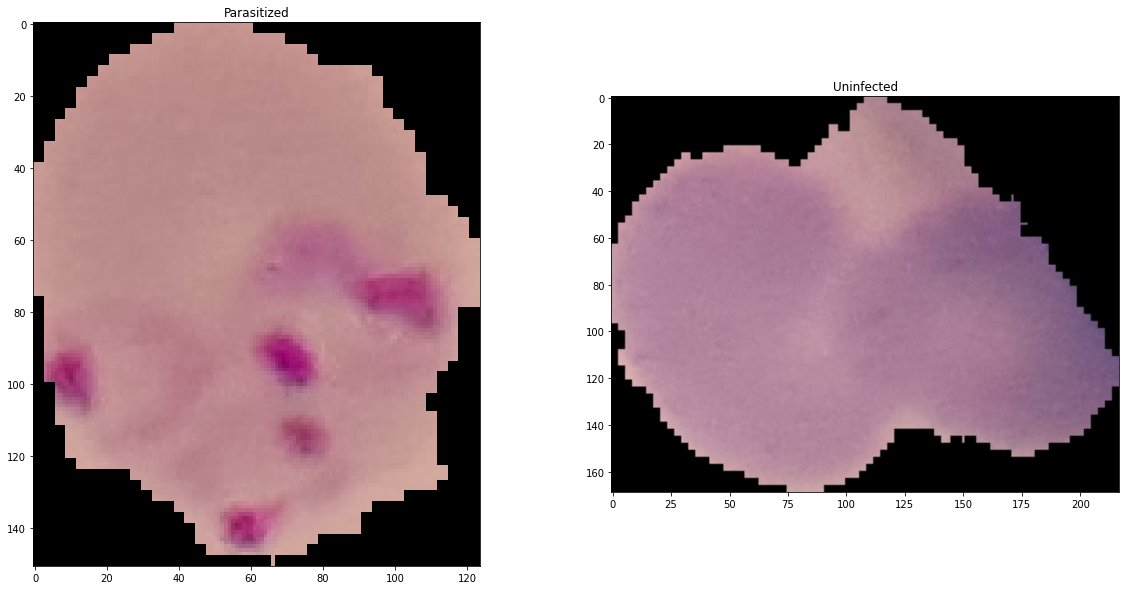

In [ ]:
# Get few samples for both the classes
malaria_samples = (train_data[train_data['label']=="Parasitized"]['images'].iloc[:1]).tolist()
normal_samples = (train_data[train_data['label']=='Uninfected']['images'].iloc[:1]).tolist()

# visualize sample images
def visualize_samples(samples):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
    for i, sample in enumerate(samples):
        img = cv2.imread(sample)
        ax[i%2].set_title(sample.split('/')[-2])
        ax[i%2].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

visualize_samples(malaria_samples + normal_samples)

parasit dapat terlihat pada parasitized cells dan pada uninfected cells tidak ada parasit. dari sini bisa terlihat bahwa data gambar bisa dirotate, flip krn tidak akan mempengaruhi analisa

In [ ]:
def visualize_data(dataframe, label):
    fig, ax = plt.subplots(figsize =(8, 5))
    ax = sns.countplot(x='label', data=dataframe, palette='Blues')
    ax.set_title('Data Distribution')
    ax.set_xlabel('Label')
    ax.set_ylabel('Count')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'),
                   (p.get_x() + p.get_width() / 2,
                    p.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),
                   textcoords='offset points')
    
    # Setting the label for x-axis
    plt.xlabel("Label", size=14)
    # Setting the label for y-axis
    plt.ylabel("Jumlah", size=14)
    # plt title base on name of 
    plt.title(f"{label} Distribution", size=10)
    plt.show()

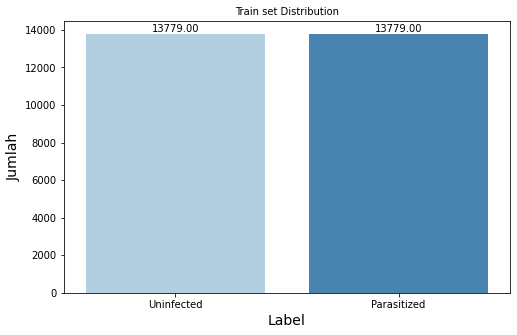

In [ ]:
visualize_data(train_data, 'Train set')

data train set uninfected dan parasitized balanced

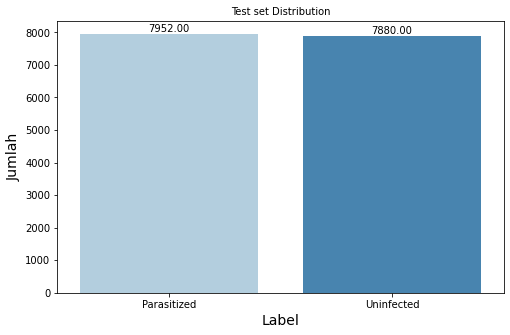

In [ ]:
visualize_data(test_data, 'Test set')

visualisasi jumlah data pada test set yang cukup balanced

In [ ]:
#check dimensions
dim1 = []
dim2 = []

for cell_filename in os.listdir(test_dir+'/Parasitized'):

    img = Image.open(test_dir+'/Parasitized/'+cell_filename)
    d1, d2 = img.size
    dim1.append(d1)
    dim2.append(d2)

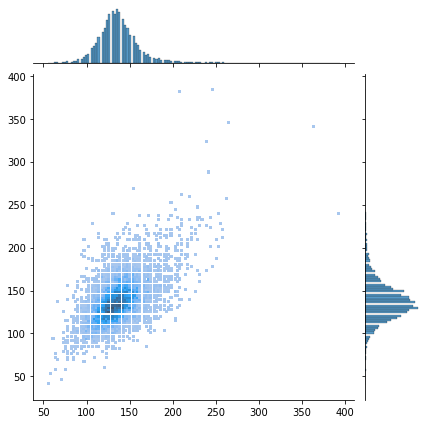

In [ ]:
sns.jointplot(x=dim1,y=dim2, kind='hist')

terlihat bahwa dimensi gambar bervariasi, size yang berbeda-beda akan menggangu proses belajar, maka gambar akan di reshape menjadi 130 x 130 sebagai ukuran mayoritas pada data



---



---



# 5 - Data Preprocessing

## Data Train and Val Split

In [ ]:
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0, stratify = train_data['label'])
print(train_data.shape)
print(val_data.shape)

(22046, 2)
(5512, 2)


data displit menjadi train, val

## Augmentasi Data

In [ ]:
img_height = 130
img_width = 130
SEED = 1
BATCH = 128

In [ ]:
# create image generator
train_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

vaL_datagen = ImageDataGenerator(
    rescale=1./255, #normalisasi pixel
    rotation_range=1,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)
test_datagen = ImageDataGenerator(rescale=1./255)

Augmentasi data menggunakan ImageDataGenerator untuk memperbesar kumpulan data menggunakan dari data yang ada. Tujuannya yaitu untuk mengurangi/mencegah overfitting untuk model yang lebih baik. Nilai rotation_range = 1 karena gambar cell lingkaran dan rotasi tidak mengubah arti dari gambar, begitu pula dengan horizontal_flip dan vertical_flip. Nilai parameter lainnya tidak = 1 untuk mencegah kesalahan model dalam deteksi gambar karena data terlalu terdistorsi.

In [ ]:
# dari dataframe bukan directory
df_train = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width), #ini buat nentuin target biar sama sizenya
    class_mode='binary',
    batch_size=BATCH,
    shuffle=True,
    seed=SEED,
    color_mode='rgb'
    )

df_val = vaL_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode='rgb'
    )

df_test = test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='images',
    y_col='label',
    target_size=(img_height, img_width),
    class_mode='binary',
    batch_size=BATCH,
    shuffle=False,
    seed=SEED,
    color_mode='rgb'
    )

Found 22046 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.
Found 15832 validated image filenames belonging to 2 classes.


In [ ]:
df_train.class_indices

{'Parasitized': 0, 'Uninfected': 1}

Parasitized ditunjukan dengan 0 dan Uninfected ditunjukan dengan 1

# 6 - Model Definition

In [ ]:
callbacks1 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 2, verbose=1), 
    ModelCheckpoint('model_best', monitor='val_loss', save_best_only=True, verbose=1) # saving the best model
 
]


Callbacks yg dipakai adalah EarlyStopping, untuk memberhentikan model saat nilai val_loss berturut-turut menurun sebanyak 2 kali. ModelCheckPoint dipakai untuk menyimpan model terbaik bedasarkan nilai val_lossnya

In [ ]:
inputs= [img_height,img_width,3]

model_1= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
model_1.add(Conv2D(filters=16, kernel_size=3, 
                            activation= 'relu', input_shape= inputs))
model_1.add(MaxPooling2D(pool_size=2, strides=2))
# boleh coba dropout dll

#Conv 2
model_1.add(Conv2D(filters=32, kernel_size=3, 
                            activation= 'relu',
                            padding='same'
                            ))
model_1.add(MaxPooling2D(pool_size=2, strides=2, 
                          padding='same'
                                  ))

#Conv 3
model_1.add(Conv2D(filters=64, kernel_size=3, activation= 'relu'))
model_1.add(MaxPooling2D(pool_size=2, strides=2))

model_1.add(Flatten())

model_1.add(Dense(units= 128, activation='relu'))
model_1.add(Dense(units= 64, activation='relu'))
model_1.add(Dense(units=1, activation='sigmoid'))

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

In [ ]:
model_1.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

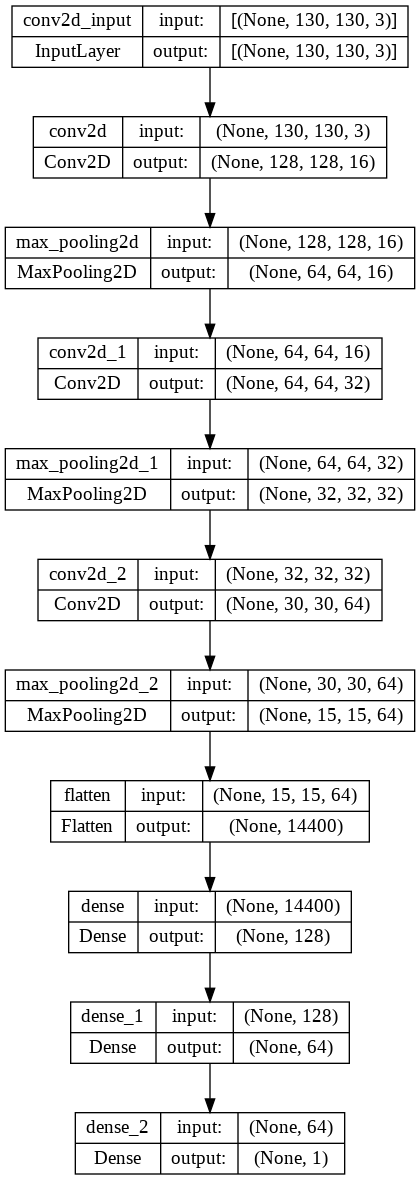

In [ ]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

proses train data menggunakan algoritma Sequential API dengan urutannya digambarkan di atas. Layer Conv2D itu untuk mengubah data yang diinputkan menjadi layers disebut feature maps. Pooling untuk mengurangi jumlah dimensi feature map sambil mempertahankan informasi yang penting. Flatten untuk menyatukan layers menjadi single vektor. Baru data dimasukan ke neural network. neural network terdiri dari 3 layer. layer pertama dengan 128 neuron, lalu 64 neuron dan terakhir outputnya 1 dengan activation sigmoid karena hasilnya binary untuk mementukan hasilnya apakan cell infected by malaria atau tidak.

In [ ]:
model_1.trainable = False

ini adalah tambahan agar model tidak belajar dari data tambahan baru

In [ ]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0

# 7 - Model Training

In [ ]:
%%time
history_1= model_1.fit(df_train, batch_size= BATCH, 
                           epochs= 10, validation_data= df_val,
                           callbacks= callbacks1) #bisa atur verbose

Epoch 1/10
173/173 [==============================] - ETA: 0s - loss: 0.5404 - accuracy: 0.7214
Epoch 1: val_loss improved from inf to 0.28201, saving model to model_best


173/173 [==============================] - 485s 3s/step - loss: 0.5404 - accuracy: 0.7214 - val_loss: 0.2820 - val_accuracy: 0.8977
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.9059
Epoch 2: val_loss improved from 0.28201 to 0.23789, saving model to model_best


173/173 [==============================] - 477s 3s/step - loss: 0.2534 - accuracy: 0.9059 - val_loss: 0.2379 - val_accuracy: 0.9093
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.2246 - accuracy: 0.9199
Epoch 3: val_loss improved from 0.23789 to 0.21479, saving model to model_best


173/173 [==============================] - 478s 3s/step - loss: 0.2246 - accuracy: 0.9199 - val_loss: 0.2148 - val_accuracy: 0.9245
Epoch 4/10
173/173 [==============================] - ETA: 0s - loss: 0.2047 - accuracy: 0.9317
Epoch 4: val_loss improved from 0.21479 to 0.20237, saving model to model_best


173/173 [==============================] - 474s 3s/step - loss: 0.2047 - accuracy: 0.9317 - val_loss: 0.2024 - val_accuracy: 0.9278
Epoch 5/10
173/173 [==============================] - ETA: 0s - loss: 0.1901 - accuracy: 0.9364
Epoch 5: val_loss improved from 0.20237 to 0.18747, saving model to model_best


173/173 [==============================] - 477s 3s/step - loss: 0.1901 - accuracy: 0.9364 - val_loss: 0.1875 - val_accuracy: 0.9343
Epoch 6/10
173/173 [==============================] - ETA: 0s - loss: 0.1863 - accuracy: 0.9382
Epoch 6: val_loss did not improve from 0.18747
173/173 [==============================] - 468s 3s/step - loss: 0.1863 - accuracy: 0.9382 - val_loss: 0.1949 - val_accuracy: 0.9343
Epoch 7/10
173/173 [==============================] - ETA: 0s - loss: 0.1771 - accuracy: 0.9423
Epoch 7: val_loss improved from 0.18747 to 0.18223, saving model to model_best


173/173 [==============================] - 477s 3s/step - loss: 0.1771 - accuracy: 0.9423 - val_loss: 0.1822 - val_accuracy: 0.9398
Epoch 8/10
173/173 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9405
Epoch 8: val_loss improved from 0.18223 to 0.17679, saving model to model_best


173/173 [==============================] - 466s 3s/step - loss: 0.1802 - accuracy: 0.9405 - val_loss: 0.1768 - val_accuracy: 0.9399
Epoch 9/10
173/173 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9411
Epoch 9: val_loss did not improve from 0.17679
173/173 [==============================] - 464s 3s/step - loss: 0.1739 - accuracy: 0.9411 - val_loss: 0.1798 - val_accuracy: 0.9389
Epoch 10/10
173/173 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9443
Epoch 10: val_loss improved from 0.17679 to 0.17667, saving model to model_best


173/173 [==============================] - 465s 3s/step - loss: 0.1675 - accuracy: 0.9443 - val_loss: 0.1767 - val_accuracy: 0.9409
CPU times: user 2h 25min 46s, sys: 2min, total: 2h 27min 46s
Wall time: 1h 22min


model dilatih dengan data train, dengan nilai batch 128 yaitu jumlah sample yang ditrain. epoch 10 adalah brp kali algoritmanya akan melewati seluruh datanya

# 8 - Model Evaluation

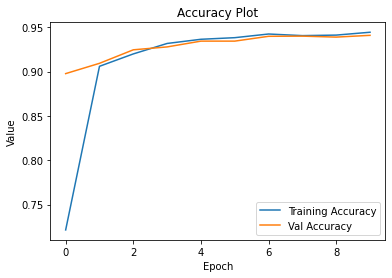

In [ ]:
plt.plot(history_1.history['accuracy'], label='Training Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

terlihat akurasinya sangat baik diatas 90% dengan naik yang tidak signifikan setelah 2 epoch

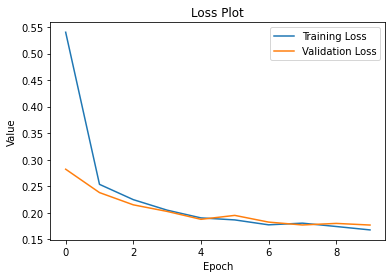

In [ ]:
#loss train & validation
plt.plot(history_1.history['loss'], label='Training Loss')
plt.plot(history_1.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

nilai lossnya baik sampai dibawah 0.2 berarti erronya kecil

In [ ]:
test_results = model_1.evaluate(df_test,
                                #verbose=0
                                )
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

124/124 [==============================] - 83s 666ms/step - loss: 0.1375 - accuracy: 0.9527
Test Loss     : 0.1375
Test Accuracy : 0.9527


nilai akurasi mencapai 95% berarti model dapat tepat mengklasifikasi 95 dari 100 gambar. nilai loss adalah nilai rata-rata error setiap batch, bukan dalam persen. nilai ideal adalah loss=0 tapi itu juga bisa menjadi indikasi overfit. namun dari grafik, tidak terlihat overfit

model ini juga akan diimprove untuk mendapatkan akurasi dan loss yang lebih baik

# 9 - Model Improvement

In [ ]:
callbacks2 = [ 
    EarlyStopping(monitor = 'val_loss', patience = 2, verbose=1), 
    ModelCheckpoint('model_best2.hdf5', monitor='val_loss', save_best_only=True, verbose=1), # saving the best model
    ReduceLROnPlateau(monitor = 'val_loss', patience = 1, factor = 0.1)
]
# callbacks1 = [
#               callbacks.EarlyStopping(monitor='val_loss', patience=2, verbose=1),
#               callbacks.ReduceLROnPlateau(monitor='val_loss',patience=2, verbose=1)
# ]

kali ini, EarlyStopping patience menjadi 2, yaitu model akan stop saat nilai val loss naik 2 kali berturut2, juga ditambahkan ReduceLROnPlateau untuk mengurangi kecepatan belajar sebanyak 10x saat val loss naik

In [ ]:
inputs= [img_height,img_width,3]

model_2= Sequential()

#Conv 1, bisa tambahkan kernel_initializer
model_2.add(Conv2D(filters=64, kernel_size=3, 
                            activation= 'relu', input_shape= inputs))
model_2.add(MaxPooling2D(pool_size=2, strides=2))
# boleh coba dropout dll

#Conv 2
model_2.add(Conv2D(filters=128, kernel_size=3, 
                            activation= 'relu',
                            padding='same'
                            ))
model_2.add(MaxPooling2D(pool_size=2, strides=2, 
                          padding='same'
                                  ))

#Conv 3
model_2.add(Conv2D(filters=128, kernel_size=3, activation= 'relu'))
model_2.add(MaxPooling2D(pool_size=2, strides=2))

model_2.add(Conv2D(filters=64, kernel_size=3, activation= 'relu', input_shape= inputs))
model_2.add(Flatten())

model_2.add(Dense(units= 256, activation='relu'))
model_2.add(Dense(units= 128, activation='relu'))
model_2.add(Dense(units= 1, activation='sigmoid'))

In [ ]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 15, 15, 128)     

proses belajarnya juga sama dengan tambahan layer sebelum flatten. total paramnya mencapai 3 juta sangat meningkat dari sblmnya yaitu 1,8 juta

In [ ]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics= ['accuracy'])

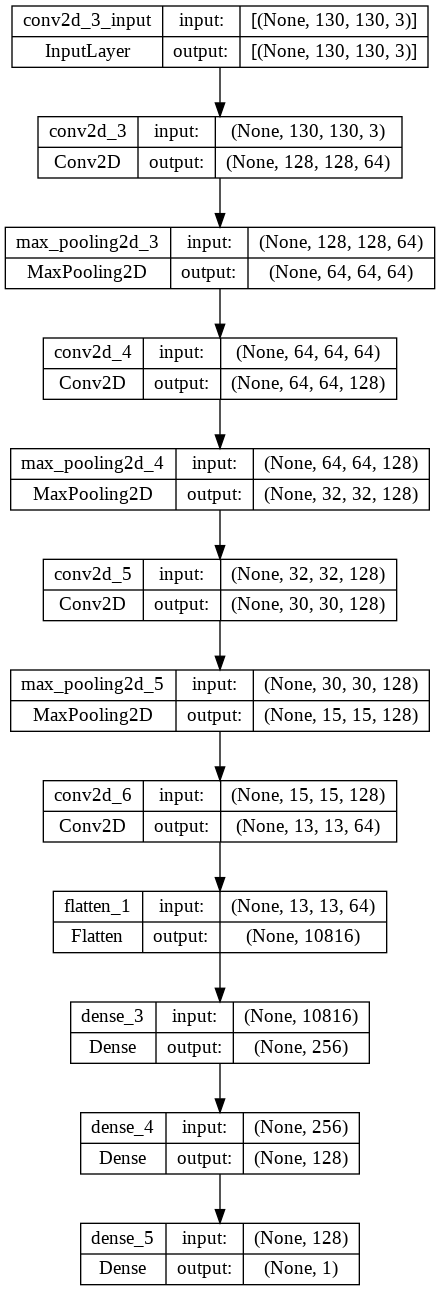

In [ ]:
tf.keras.utils.plot_model(model_2, show_shapes=True)

In [ ]:
model_2.trainable = False

In [ ]:
%%time
history_2= model_2.fit(df_train, batch_size= 64, 
                           epochs= 10, validation_data= df_val,
                           callbacks= callbacks2) #bisa atur verbose

Epoch 1/10
173/173 [==============================] - ETA: 0s - loss: 0.5492 - accuracy: 0.6748
Epoch 1: val_loss improved from inf to 0.28648, saving model to model_best2.hdf5
173/173 [==============================] - 1862s 11s/step - loss: 0.5492 - accuracy: 0.6748 - val_loss: 0.2865 - val_accuracy: 0.9002 - lr: 0.0010
Epoch 2/10
173/173 [==============================] - ETA: 0s - loss: 0.2327 - accuracy: 0.9184
Epoch 2: val_loss improved from 0.28648 to 0.20854, saving model to model_best2.hdf5
173/173 [==============================] - 1847s 11s/step - loss: 0.2327 - accuracy: 0.9184 - val_loss: 0.2085 - val_accuracy: 0.9312 - lr: 0.0010
Epoch 3/10
173/173 [==============================] - ETA: 0s - loss: 0.2052 - accuracy: 0.9328
Epoch 3: val_loss improved from 0.20854 to 0.20081, saving model to model_best2.hdf5
173/173 [==============================] - 1843s 11s/step - loss: 0.2052 - accuracy: 0.9328 - val_loss: 0.2008 - val_accuracy: 0.9331 - lr: 0.0010
Epoch 4/10
173/173 [

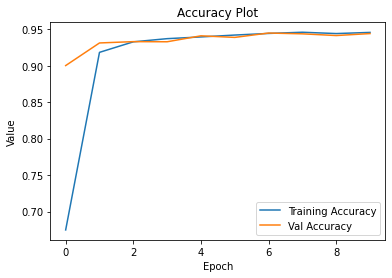

In [ ]:
plt.plot(history_2.history['accuracy'], label='Training Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value') 
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

grafik akurasi terlihat kurang lebih sama dengan akurasi 90%

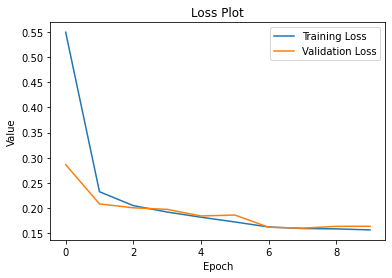

In [ ]:
#loss train & validation
plt.plot(history_2.history['loss'], label='Training Loss')
plt.plot(history_2.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

nilai val loss juga baik dengan nilai error dibawah 0.2

In [ ]:
test_results = model_2.evaluate(df_test,
                                #verbose=0
                                )
print(f'Test Loss     : {test_results[0]:.4f}')
print(f'Test Accuracy : {test_results[1]:.4f}')

124/124 [==============================] - 327s 3s/step - loss: 0.1311 - accuracy: 0.9551
Test Loss     : 0.1311
Test Accuracy : 0.9551


setelah model diimprove ternyata nilai akurasi dan loss membaik namun tidak signifikan. dengan nilai loss awal 0.1375 dan yang diimprove 0.1311. nilai akurasi awal 0.9527 dan yang diimprove 0.9551

karena improvement yang tidak signifikan, kami hanya akan menggunakan model pertama dengan params yang jauh lebih sedikit agar tidak menyianyiakan resource komputer dan waktu

# 10 - Model Saving

Model yang dipilih adalah model_1

In [ ]:
with open('model_1.pkl', 'wb') as file_1:
  joblib.dump(model_1, file_1)

# 11 - Model Inference

## Load Model

In [ ]:
with open('model_1.pkl', 'rb') as file_1:
  model_1 = joblib.load(file_1) 

## Inferencing

In [ ]:
inf

'/content/images/Malaria Cells/single_prediction'

In [ ]:
inf_normal = glob.glob("/content/images/Malaria Cells/single_prediction/Uninfected.png")
inf_malaria = glob.glob("/content/images/Malaria Cells/single_prediction/Parasitised.png")

In [ ]:
img_normal = Image. open('/content/images/Malaria Cells/single_prediction/Uninfected.png')

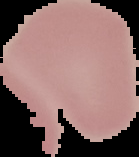

In [ ]:
img_normal

Gambar cell uninfected

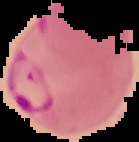

In [ ]:
img_malaria = Image. open('/content/images/Malaria Cells/single_prediction/Parasitised.png')
img_malaria

gambar cell parasitised

In [ ]:
normal_inf = create_dataframe(inf_normal)
normal_inf = normal_inf.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
print(normal_inf.shape)
normal_inf

(1, 2)


,images,label
0,/content/images/Malaria Cells/single_predictio...,single_prediction


In [ ]:
malaria_inf = create_dataframe(inf_malaria)
malaria_inf = malaria_inf.sample(frac=1, random_state=0).reset_index(drop=True)

In [ ]:
print(malaria_inf.shape)
malaria_inf

(1, 2)


,images,label
0,/content/images/Malaria Cells/single_predictio...,single_prediction


## Testing

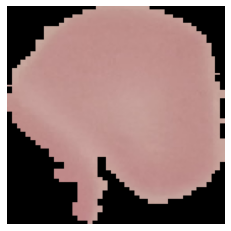

1/1 [==============================] - 0s 24ms/step
[[0.954931]]
Uninfected


In [ ]:
  # Prediksi dengan mengunggah gambar
path = inf_normal[0]
img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
plt.imshow(img)
plt.axis('Off')
plt.show()
x = utils.img_to_array(img) # untuk ubah image kedalam array
x = x/255.
x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

images = np.vstack([x])
classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
print(classes) 
if classes[0][0] >= 0.5:
    print('Uninfected')
else:
    print('Infected by malaria')

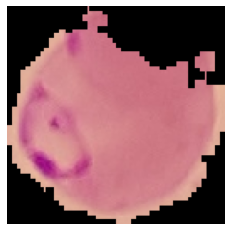

1/1 [==============================] - 0s 23ms/step
[[4.694965e-06]]
Infected by malaria


In [ ]:
# Prediksi dengan mengunggah gambar
path = inf_malaria[0]
img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
plt.imshow(img)
plt.axis('Off')
plt.show()
x = utils.img_to_array(img) # untuk ubah image kedalam array
x = x/255.
x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

images = np.vstack([x])
classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
print(classes) 
if classes[0][0] >= 0.5 :
    print('Uninfected')
else:
    print('Infected by malaria')

Saving no_malaria.png to no_malaria (1).png


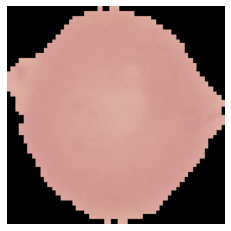

1/1 [==============================] - 0s 26ms/step
[[0.98841834]]
Uninfected


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = utils.img_to_array(img) # untuk ubah image kedalam array
  x = x/255.
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] >= 0.5:
    print('Uninfected')
  else:
    print('Infected by malaria')

Saving no_sakit.png to no_sakit (2).png


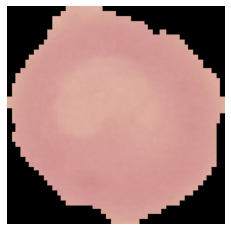

1/1 [==============================] - 0s 23ms/step
[[0.9930244]]
Uninfected


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = utils.img_to_array(img) # untuk ubah image kedalam array
  x = x/255.
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] >= 0.5:
    print('Uninfected')
  else:
    print('Infected by malaria')

Saving malaria2.png to malaria2 (1).png


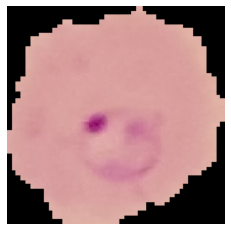

1/1 [==============================] - 0s 23ms/step
[[0.00226328]]
Infected by malaria


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = utils.img_to_array(img) # untuk ubah image kedalam array
  x = x/255.
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] >= 0.5:
    print('Uninfected')
  else:
    print('Infected by malaria')

Saving not_infected.png to not_infected (1).png


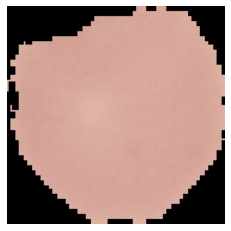

1/1 [==============================] - 0s 26ms/step
[[0.98862416]]
Uninfected


In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = utils.img_to_array(img) # untuk ubah image kedalam array
  x = x/255.
  x = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]

  images = np.vstack([x])
  classes = model_1.predict(images) #gunakan model yang terbaik misal yg variable my_model untuk predict images
  print(classes) 
  if classes[0][0] >= 0.5:
    print('Uninfected')
  else:
    print('Infected by malaria')

## Inference dengan backend

Saving malaria3.png to malaria3.png


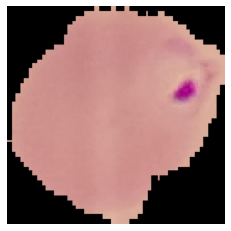

In [ ]:
uploaded = files.upload()

for fn in uploaded.keys():
 
  # Prediksi dengan mengunggah gambar
  path = fn
  img = utils.load_img(path, target_size=(130,130), color_mode='rgb') #harus sama dengan model kita
  plt.imshow(img)
  plt.axis('Off')
  plt.show()
  x = utils.img_to_array(img) # untuk ubah image kedalam array
  x = x/255.
  x_1 = np.expand_dims(x, axis=0) #Memperluas bentuk array misal 1D jadi 2D, 0 berarti baris/horizontal [[1, 2]]


In [ ]:
import json

data = json.dumps({
    "signature_name": "serving_default",
    "instances": x_1.tolist()
})

data

'{"signature_name": "serving_default", "instances": [[[[0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.8470588326454163, 0.6627451181411743, 0.5921568870544434],

In [ ]:
import requests

URL = "http://tfserving-back-prajna.herokuapp.com/v1/models/model_1:predict"
r = requests.post(URL, data)
r

<Response [200]>

In [ ]:
res = r.json()
res

{'predictions': [[6.87072898e-05]]}

gambar cell dengan malaria

# 12 - Kesimpulan

- parasit dapat terlihat pada parasitized cells dan pada uninfected cells tidak ada parasit. dari sini bisa terlihat bahwa data gambar bisa dirotate, flip krn tidak akan mempengaruhi analisa. 

- jumlah data train dan set balance. 

- terlihat bahwa dimensi gambar bervariasi, size yang berbeda-beda akan menggangu proses belajar, maka gambar akan di reshape menjadi 130 x 130 sebagai ukuran mayoritas pada data. 

- Augmentasi data menggunakan ImageDataGenerator untuk memperbesar kumpulan data menggunakan dari data yang ada. Tujuannya yaitu untuk mengurangi/mencegah overfitting untuk model yang lebih baik. Nilai rotation_range = 1 karena gambar cell lingkaran dan rotasi tidak mengubah arti dari gambar, begitu pula dengan horizontal_flip dan vertical_flip. Nilai parameter lainnya tidak = 1 untuk mencegah kesalahan model dalam deteksi gambar karena data terlalu terdistorsi. 

- Callbacks yg dipakai adalah EarlyStopping, untuk memberhentikan model saat nilai val_loss berturut-turut menurun sebanyak 2 kali. ModelCheckPoint dipakai untuk menyimpan model terbaik bedasarkan nilai val_lossnya. 

- proses train data menggunakan algoritma Sequential API dengan urutannya digambarkan di atas. Layer Conv2D itu untuk mengubah data yang diinputkan menjadi layers disebut feature maps. Pooling untuk mengurangi jumlah dimensi feature map sambil mempertahankan informasi yang penting. Flatten untuk menyatukan layers menjadi single vektor. Baru data dimasukan ke neural network. neural network terdiri dari 3 layer. layer pertama dengan 128 neuron, lalu 64 neuron dan terakhir outputnya 1 dengan activation sigmoid karena hasilnya binary untuk mementukan hasilnya apakan cell infected by malaria atau tidak.

- model dilatih dengan data train, dengan nilai batch 128 yaitu jumlah sample yang ditrain. epoch 10 adalah brp kali algoritmanya akan melewati seluruh datanya.

- terlihat akurasinya sangat baik diatas 90% dengan naik yang tidak signifikan setelah 2 epoch

- nilai akurasi mencapai 95% berarti model dapat tepat mengklasifikasi 95 dari 100 gambar. nilai loss adalah nilai rata-rata error setiap batch, bukan dalam persen. nilai ideal adalah loss=0 tapi itu juga bisa menjadi indikasi overfit. namun dari grafik, tidak terlihat overfit

- setelah model diimprove ternyata nilai akurasi dan loss membaik namun tidak signifikan. dengan nilai loss awal 0.1375 dan yang diimprove 0.1311. nilai akurasi awal 0.9527 dan yang diimprove 0.9551. karena improvement yang tidak signifikan, kami hanya akan menggunakan model pertama dengan params yang jauh lebih sedikit agar tidak menyianyiakan resource komputer dan waktu